In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.0.0


In [ ]:
pos_path = '../data/pos/'
neg_path = '../data/neg/'
pos_list = os.listdir(pos_path)
neg_list = os.listdir(neg_path)

In [ ]:
train_data = []
train_label = []
for doc in pos_list:
    with open(pos_path + doc, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            train_data.append(line)
            train_label.append(1)
            
for doc in neg_list:
    with open(neg_path + doc, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            train_data.append(line)
            train_label.append(0)

In [2]:
# imdb = keras.datasets.imdb
# (train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=100)
train_data = []
train_labels = []
with open("../data/demo.txt", "r", encoding="utf-8") as lines:
    for line in lines.readlines():
        words = line.split(",")
        train_labels.append(np.int64(int(words[0])))
#         train_data.append(np.array(words[1].split(" ")))
        train_data.append(np.array(keras.preprocessing.text.one_hot(words[1], 100)))
train_data = np.array(train_data)
train_labels = np.array(train_labels)

In [3]:
type(train_data), type(train_data[0]), type(train_data[0][0])

(numpy.ndarray, numpy.ndarray, numpy.int64)

In [4]:
 type(train_labels),type(train_labels[0])

(numpy.ndarray, numpy.int64)

In [5]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 50, labels: 50


In [6]:
print(train_data[0])

[26  7 91 89  7 91 77 78  1 21  8 96 95 17  8 91 71 98 35 71 96 20 41  4
 64  7 40 91 33 18 90 66 70 37 27 99 25 61 81 82 67 96 82 62 47 49 25 59
  3 18 47 13 86 29  4  1 77 78 11  7 96 37 22 25  9 34 79  7 91 70 61 37
 25]


In [7]:
print(train_labels[0])

0


In [8]:
len(train_data[0]), len(train_data[1])

(73, 11)

## 准备数据

影评——即整数数组必须在输入神经网络之前转换为张量。这种转换可以通过以下两种方式来完成：

* 将数组转换为表示单词出现与否的由 0 和 1 组成的向量，类似于 one-hot 编码。例如，序列[3, 5]将转换为一个 10,000 维的向量，该向量除了索引为 3 和 5 的位置是 1 以外，其他都为 0。然后，将其作为网络的首层——一个可以处理浮点型向量数据的稠密层。不过，这种方法需要大量的内存，需要一个大小为 `num_words * num_reviews` 的矩阵。

* 或者，我们可以填充数组来保证输入数据具有相同的长度，然后创建一个大小为 `max_length * num_reviews` 的整型张量。我们可以使用能够处理此形状数据的嵌入层作为网络中的第一层。

在本教程中，我们将使用第二种方法。

由于电影评论长度必须相同，我们将使用 [pad_sequences](https://tensorflow.google.cn/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) 函数来使长度标准化：

In [9]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        dtype='str',
                                                        padding='post',
                                                        maxlen=128)

In [10]:
print(train_data[1])

['9' '8' '1' '7' '9' '8' '3' '7' '7' '1' '2' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '0'
 '0' '0']


## 构建模型

神经网络由堆叠的层来构建，这需要从两个主要方面来进行体系结构决策：

* 模型里有多少层？
* 每个层里有多少*隐层单元（hidden units）*？

在此样本中，输入数据包含一个单词索引的数组。要预测的标签为 0 或 1。让我们来为该问题构建一个模型：

In [11]:
# 输入形状是用于电影评论的词汇数目（10,000 词）
vocab_size = 100

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          1600      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,889
Trainable params: 1,889
Non-trainable params: 0
_________________________________________________________________


层按顺序堆叠以构建分类器：

1. 第一层是`嵌入（Embedding）`层。该层采用整数编码的词汇表，并查找每个词索引的嵌入向量（embedding vector）。这些向量是通过模型训练学习到的。向量向输出数组增加了一个维度。得到的维度为：`(batch, sequence, embedding)`。
2. 接下来，`GlobalAveragePooling1D` 将通过对序列维度求平均值来为每个样本返回一个定长输出向量。这允许模型以尽可能最简单的方式处理变长输入。
3. 该定长输出向量通过一个有 16 个隐层单元的全连接（`Dense`）层传输。
4. 最后一层与单个输出结点密集连接。使用 `Sigmoid` 激活函数，其函数值为介于 0 与 1 之间的浮点数，表示概率或置信度。

### 隐层单元

上述模型在输入输出之间有两个中间层或“隐藏层”。输出（单元，结点或神经元）的数量即为层表示空间的维度。换句话说，是学习内部表示时网络所允许的自由度。

如果模型具有更多的隐层单元（更高维度的表示空间）和/或更多层，则可以学习到更复杂的表示。但是，这会使网络的计算成本更高，并且可能导致学习到不需要的模式——一些能够在训练数据上而不是测试数据上改善性能的模式。这被称为*过拟合（overfitting）*，我们稍后会对此进行探究。

### 损失函数与优化器

一个模型需要损失函数和优化器来进行训练。由于这是一个二分类问题且模型输出概率值（一个使用 sigmoid 激活函数的单一单元层），我们将使用 `binary_crossentropy` 损失函数。

这不是损失函数的唯一选择，例如，您可以选择 `mean_squared_error` 。但是，一般来说 `binary_crossentropy` 更适合处理概率——它能够度量概率分布之间的“距离”，或者在我们的示例中，指的是度量 ground-truth 分布与预测值之间的“距离”。

稍后，当我们研究回归问题（例如，预测房价）时，我们将介绍如何使用另一种叫做均方误差的损失函数。

现在，配置模型来使用优化器和损失函数：

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 创建一个验证集

在训练时，我们想要检查模型在未见过的数据上的准确率（accuracy）。通过从原始训练数据中分离 10,000 个样本来创建一个*验证集*。（为什么现在不使用测试集？我们的目标是只使用训练数据来开发和调整模型，然后只使用一次测试数据来评估准确率（accuracy））。

In [13]:
train_data = train_data.astype(np.int64)

In [14]:
train_size = 20
x_val = train_data[:train_size]
partial_x_train = train_data[train_size:]

y_val = train_labels[:train_size]
partial_y_train = train_labels[train_size:]

## 训练模型

以 512 个样本的 mini-batch 大小迭代 40 个 epoch 来训练模型。这是指对 `x_train` 和 `y_train` 张量中所有样本的的 40 次迭代。在训练过程中，监测来自验证集的 10,000 个样本上的损失值（loss）和准确率（accuracy）：

In [15]:
type(partial_x_train), type(partial_x_train[0]), type(partial_x_train[0][0])

(numpy.ndarray, numpy.ndarray, numpy.int64)

In [16]:
type(partial_y_train),type(partial_y_train[0])

(numpy.ndarray, numpy.int64)

In [17]:
type(x_val), type(x_val[0]), type(x_val[0][0])

(numpy.ndarray, numpy.ndarray, numpy.int64)

In [18]:
type(y_val),type(y_val[0])

(numpy.ndarray, numpy.int64)

In [19]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 30 samples, validate on 20 samples
Epoch 1/40
30/30 [==============================] - 1s 26ms/sample - loss: 0.6919 - accuracy: 0.6000 - val_loss: 0.6952 - val_accuracy: 0.4000
Epoch 2/40
30/30 [==============================] - 0s 408us/sample - loss: 0.6913 - accuracy: 0.6000 - val_loss: 0.6958 - val_accuracy: 0.4000
Epoch 3/40
30/30 [==============================] - 0s 500us/sample - loss: 0.6907 - accuracy: 0.6000 - val_loss: 0.6965 - val_accuracy: 0.4000
Epoch 4/40
30/30 [==============================] - 0s 556us/sample - loss: 0.6902 - accuracy: 0.6000 - val_loss: 0.6971 - val_accuracy: 0.4000
Epoch 5/40
30/30 [==============================] - 0s 581us/sample - loss: 0.6896 - accuracy: 0.6000 - val_loss: 0.6978 - val_accuracy: 0.4000
Epoch 6/40
30/30 [==============================] - 0s 532us/sample - loss: 0.6891 - accuracy: 0.6000 - val_loss: 0.6984 - val_accuracy: 0.4000
Epoch 7/40
30/30 [==============================] - 0s 510us/sample - loss: 0.6887 - accuracy

## 评估模型

我们来看一下模型的性能如何。将返回两个值。损失值（loss）（一个表示误差的数字，值越低越好）与准确率（accuracy）。

In [20]:
# results = model.evaluate(test_data,  test_labels, verbose=2)
# print(results)
results = model.evaluate(train_data,  train_labels, verbose=2)
print(results)

50/1 - 0s - loss: 0.6706 - accuracy: 0.5200
[0.6961713790893554, 0.52]


这种十分朴素的方法得到了约 87% 的准确率（accuracy）。若采用更好的方法，模型的准确率应当接近 95%。

## 创建一个准确率（accuracy）和损失值（loss）随时间变化的图表

`model.fit()` 返回一个 `History` 对象，该对象包含一个字典，其中包含训练阶段所发生的一切事件：

In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'loss', 'accuracy', 'val_accuracy'])

有四个条目：在训练和验证期间，每个条目对应一个监控指标。我们可以使用这些条目来绘制训练与验证过程的损失值（loss）和准确率（accuracy），以便进行比较。

In [22]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# “bo”代表 "蓝点"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b代表“蓝色实线”
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

<Figure size 640x480 with 1 Axes>

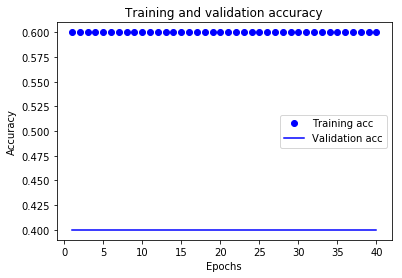

In [23]:
plt.clf()   # 清除数字

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


在该图中，点代表训练损失值（loss）与准确率（accuracy），实线代表验证损失值（loss）与准确率（accuracy）。

注意训练损失值随每一个 epoch *下降*而训练准确率（accuracy）随每一个 epoch *上升*。这在使用梯度下降优化时是可预期的——理应在每次迭代中最小化期望值。

验证过程的损失值（loss）与准确率（accuracy）的情况却并非如此——它们似乎在 20 个 epoch 后达到峰值。这是过拟合的一个实例：模型在训练数据上的表现比在以前从未见过的数据上的表现要更好。在此之后，模型过度优化并学习*特定*于训练数据的表示，而不能够*泛化*到测试数据。

对于这种特殊情况，我们可以通过在 20 个左右的 epoch 后停止训练来避免过拟合。稍后，您将看到如何通过回调自动执行此操作。